#**1. Transformer**

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

###**1.1. Transformer-Encoder**

####**Token and Positional Embedding**

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

####**Transformer-Encoder Block**

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

####**Transformer-Encoder**

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            src_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for i in range(num_layers)
            ]
        )

    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

In [5]:
batch_size = 32
src_vocab_size = 1000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [6]:
input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [7]:
input.shape

torch.Size([32, 100])

In [8]:
encoder = TransformerEncoder(
    src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [9]:
encoded = encoder(input)

In [10]:
encoded.shape

torch.Size([32, 100, 200])

###**1.2. Transformer-Decoder**

####**Transformer Decoder Block**

In [11]:
class TransformerDecoderBlock(nn.Monum_headsential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out_1, enc_output, enc_output, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(out_1 + attn_output)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_2(ffn_output)
        out_3 = self.layernorm_2(out_2 + ffn_output)
        return out_3

####**Transformer-Decoder**

In [12]:
class TransformerDecoder(nn.Module):
    def __init__(self,
            tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim,
            dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            tgt_vocab_size, embed_dim, max_length, device
        )
        self.layers = nn.ModuleList(
            [
                TransformerDecoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for i in range(num_layers)
            ]
        )

    def forward(self, x, enc_output, src_mask, tgt_mask):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, enc_output, src_mask, tgt_mask)
        return output

###**1.3. Transformer**

In [13]:
class Transformer(nn.Module):
    def __init__(self,
            src_vocab_size, tgt_vocab_size,
            embed_dim, max_length, num_layers, num_heads, ff_dim,
            dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.device = device
        self.encoder = TransformerEncoder(
            src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
        )
        self.decoder = TransformerDecoder(
            tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
        )
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]

        src_mask = torch.zeros(
            (src_seq_len, src_seq_len),
            device=self.device).type(torch.bool)

        tgt_mask = (torch.triu(torch.ones(
            (tgt_seq_len, tgt_seq_len),
            device=self.device)
        ) == 1).transpose(0, 1)
        tgt_mask = tgt_mask.float().masked_fill(
            tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [14]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [15]:
model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [16]:
src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)
src.shape

torch.Size([128, 100])

In [17]:
tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)
tgt.shape

torch.Size([128, 100])

In [18]:
prediction = model(src, tgt)

In [19]:
prediction.shape

torch.Size([128, 100, 2000])

#**2. Text Classification using Transformer-Encoder**

###**2.1. Load Dataset**

In [20]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [21]:
folder_paths = {
    'train': 'data/ntc-scv/train',
    'valid': 'data/ntc-scv/valid',
    'test': 'data/ntc-scv/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [22]:
train_df

,sentence,label
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0
...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1


###**2.2. Preprocessing**

**Text Cleaning**

In [23]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [24]:
train_df['sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

###**2.3. Representation**

In [25]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [26]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [28]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df['sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [31]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

###**2.4. Dataloader**

In [37]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [39]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [40]:
next(iter(train_dataloader))

(tensor([[   6,   60, 1614,  ...,    0,    0,    0],
         [ 119,  227,  186,  ...,  938,   83,   71],
         [   7,   36,   65,  ...,    0,    0,    0],
         ...,
         [   3, 1097,  258,  ...,  467,   10,   62],
         [ 442,   32,  161,  ...,    0,    0,    0],
         [ 164,  657,   18,  ...,    0,    0,    0]]),
 tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
         1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
         1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
         1, 1, 1, 0, 1, 0, 1, 0]))

In [41]:
len(train_dataloader)

235

In [42]:
encoded_sentences, labels = next(iter(train_dataloader))

In [43]:
encoded_sentences.shape

torch.Size([128, 100])

In [44]:
labels.shape

torch.Size([128])

###**2.5. Trainer**

In [45]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [46]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [47]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [48]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

###**2.6. Modeling**

In [49]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [50]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

In [51]:
encoded_sentences.shape

torch.Size([128, 100])

In [52]:
predictions = model(encoded_sentences)

In [53]:
predictions.shape

torch.Size([128, 2])

###**2.7. Training**

In [54]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.538
| epoch   1 |   100/  235 batches | accuracy    0.585
| epoch   1 |   150/  235 batches | accuracy    0.673
| epoch   1 |   200/  235 batches | accuracy    0.720
-----------------------------------------------------------
| End of epoch   1 | Time: 17.59s | Train Accuracy    0.729 | Train Loss    0.637 | Valid Accuracy    0.750 | Valid Loss    0.538 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.766
| epoch   2 |   100/  235 batches | accuracy    0.774
| epoch   2 |   150/  235 batches | accuracy    0.789
| epoch   2 |   200/  235 batches | accuracy    0.788
-----------------------------------------------------------
| End of epoch   2 | Time: 17.57s | Train Accuracy    0.791 | Train Loss    0.479 | Valid Accuracy    0.783 | Valid Loss    0.457 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.805
| epoch   3 

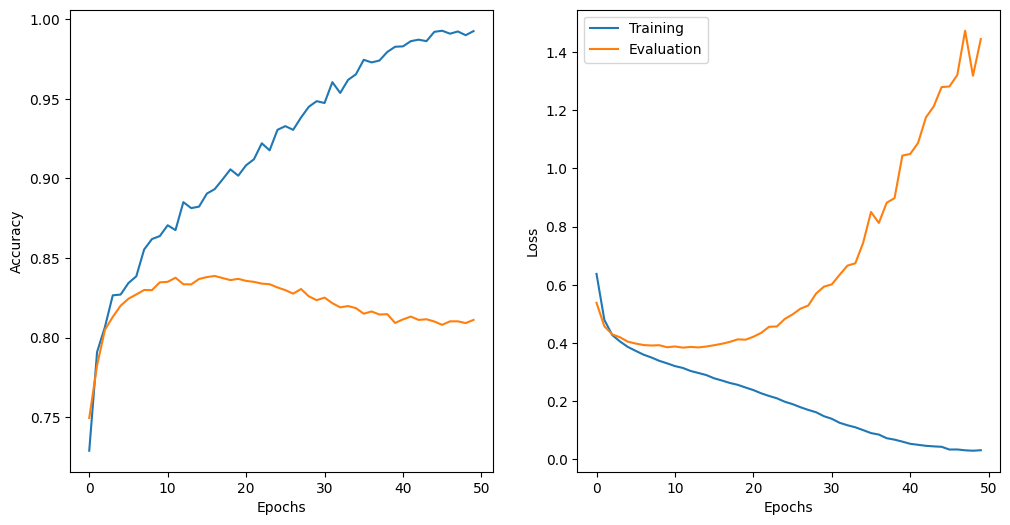

In [55]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [56]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.82, 1.3323042747340625)

#**3. Text Classification using BERT**

In [ ]:
# !pip install -q -U transformers datasets accelerate evaluate

###**3.1. Load Dataset**

In [57]:
from datasets import Dataset, DatasetDict

raw_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test': Dataset.from_pandas(test_df)
})

In [58]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10000
    })
})

###**3.2. Preprocessing**

In [59]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [61]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts

    result = tokenizer(
        examples["sentence"],
        padding="max_length",
        max_length=max_seq_length,
        truncation=True
    )
    result["label"] = examples['label']

    return result

In [62]:
# Running the preprocessing pipeline on all the datasets
processed_dataset = raw_dataset.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/30000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [63]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [66]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

###**3.3. Modeling**

In [67]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="text-classification"
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

###**3.4. Metric**

In [69]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

###**3.5. Trainer**

In [70]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="save_model",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

###**3.6. Training**

In [71]:
trainer.train()

  0%|          | 0/2350 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 14.69 MiB is free. Including non-PyTorch memory, this process has 3.63 GiB memory in use. Process 90439 has 168.00 MiB memory in use. Of the allocated memory 3.49 GiB is allocated by PyTorch, and 61.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
trainer.evaluate(processed_dataset["test"])